# Defining the classes

### Piece should be represented as some box figure
Each piece has the shape (can be meant as volume), color (meant as, surprisingly, color), and label (piece name, it is mostly for us than for algo)

### House - the set of rooms with doors
Do not forget - each House must have at least 1 door at exterior walls

### Metrics
We expect you to measure all objects in centimeters. Thus, $100 m^2 = 1000*1000 = 1000000 cm^2$

In [261]:
import cv2
import numpy as np
from scipy.ndimage import zoom as scipy_zoom
import matplotlib.pyplot as plt
from typing import List
from sklearn.cluster import SpectralClustering
from random import randint
import warnings
warnings.filterwarnings('ignore')


meter, sq_meter = 100, 1e4


class Piece:
    """Represents the piece of furnuture via position, color and, optionally, label."""
    def __init__(self, position: np.ndarray, color: str, label=None):
        self.color, self.position, self.label = color, position, label
    
    def size(self):
        """Returns the sizes of Piece in two dimensions."""
        return (self.position[:, 0].max() - self.position[:, 0].min(), 
                self.position[:, 1].max() - self.position[:, 1].min())


class House:
    """
        Actually, the House/Apartments/Dungeon model.
        
        @param exterior_pts: mandatory NumPy array, responsible for exterior walls. Can be meant as external contour.
        @param interior_pts: optional NumPy array, responsible for interior walls. Can be meant as internal contours.
        @param doors: optional NumPy array, responsible for doors locations. Can be meant as series of intervals on interior_pts.
        @param title: optional string, responsible for the House name.
        
        @return: House object.
    """
    def __init__(self, exterior_pts: np.ndarray, interior_pts: np.ndarray = None,
                 doors: np.ndarray = None, title: str = None, **kwargs):
        # This field defines the walls of house
        self.exterior_points: np.ndarray = exterior_pts
        # Room: set of corner points; shape=[Rooms, CornersInRoom, 2, 2]
        self.rooms: np.ndarray = interior_pts
        # Room labels: mostly for tracking, what piece goes to what room
        self.room_labels: list = None
        # Doors: set of lines. Doors.shape=[N,2,2]
        self.doors: np.ndarray = doors
        # Pieces, distributed by rooms; shape=[RoomNumber, Piece]
        self.pieces: List[List[Piece]] = None
        # Title of house
        self.title: str = title

    def draw(self):
        # Create figure
        figure, axes = plt.subplots(figsize=(10,10))
        plt.title(self.title)

        # Draw exterior walls
        if self.exterior_points is not None:
            x=np.append(self.exterior_points[:, 0], self.exterior_points[0, 0])
            y=np.append(self.exterior_points[:, 1], self.exterior_points[0, 1])
            plt.plot(x, y, linewidth=5.0, color='black', label='Wall')
            plt.fill_between(x, y, color="gray")
        
        # Draw interior walls
        if self.rooms is not None:
            for i in range(self.rooms.shape[0]):
                buf = self.rooms[i].reshape((self.rooms[i].shape[0], self.rooms[i].shape[2]))
                plt.plot(np.append(buf[:, 0], buf[0, 0]), 
                         np.append(buf[:, 1], buf[0, 1]),
                         linewidth=2.0, color='black')
        # Draw pieces
        if self.pieces is not None:
            for room_pieces in self.pieces:
                for piece in room_pieces:
                    x = np.append(piece.position[:, 0], piece.position[0, 0])
                    y = np.append(piece.position[:, 1], piece.position[0, 1])
                    plt.plot(x, y, linewidth=3.0, color=piece.color, visible=False)
                    plt.fill_between(x, y, color=piece.color)
                    plt.text(x.mean(), y.mean(), piece.label)
                    
        # Draw doors
        if self.doors is not None:
            def pt(r, phi, cx, cy):
                return cx + r*np.cos(phi), cy + r*np.sin(phi)
            phis=np.arange(0, 2*np.pi,0.01)
            
            plt.plot(self.doors[0, :, 0], self.doors[0, :, 1], linewidth=4.0, color='green', label='Door location')
            for i in range(1, self.doors.shape[0]):
                length = self.doors[i, :, 0].max() - self.doors[i, :, 0].min() + self.doors[i, :, 1].max() - self.doors[i, :, 1].min()
                cx = (self.doors[i, :, 0].max() + self.doors[i, :, 0].min()) / 2
                cy = (self.doors[i, :, 1].max() + self.doors[i, :, 1].min()) / 2
                z = pt(length/2, phis, cx, cy)
                plt.plot(*z, linewidth=4.0, color='green')
        
        # Final points
        plt.xlim(self.exterior_points[:, 0].min() - 3, self.exterior_points[:, 0].max() + 3)
        plt.ylim(self.exterior_points[:, 1].min() - 3, self.exterior_points[:, 1].max() + 3)
        plt.legend()
        plt.show()

# Algorithms

## Rooms generator
* Create the house with external walls as parameter;
* Create the mask in squared meters;
* Clusterize the mask -> create the rooms;
* Parse the mask borders in order to define the walls;
* For one of external walls, add the door;
* For each internal wall, create the door;
* Store all walls and doors in the house;
* Return "roomed" house.

In [266]:
def _split_model(model: np.ndarray, sections: int) -> np.ndarray:
    """Returns labelled field model. Clustering is done via scikit-learn.cluster.SpectralClustering"""
    data = np.asarray([[i, j] for i in range(model.shape[0]) for j in range(model.shape[1])])
    res = SpectralClustering(n_clusters=sections).fit_predict(data).reshape(model.shape)
    return np.round(res)
        
        
def generate_rooms(rooms_cnt: int = 5, exterior_pts: np.ndarray = np.asarray([[0, 0], [0, 1000], [1000, 1000], [1000, 0]])) -> House:
    """
        Creates and clusterizes the cells' graph as rooms' representer.
        
        @param rooms_cnt: integer, amount of rooms to be created.
        @exterior_pts: NumPy array, exterior walls for the House object.
        
        @return: House object, with generated rooms & doors.
    """    
    house = House(exterior_pts=exterior_pts)
    
    # We do not generate the rooms for houses with square not divisable on meters
    if int(cv2.contourArea(house.exterior_points) / sq_meter) <= 1:
        return house
    if rooms_cnt < 0 or rooms_cnt > 10:
        return house
    
    # Split the celled house on rooms=clusters 
    model = _split_model(sections=rooms_cnt, model=np.zeros(shape=(
        (house.exterior_points[:, 0].max() - house.exterior_points[:, 0].min()) // meter, 
        (house.exterior_points[:, 1].max() - house.exterior_points[:, 1].min()) // meter), dtype=float))
    
    # Parse celled model on house
    model = model.repeat(100, axis=0).repeat(100, axis=1)
    data, contours, hierarchy = cv2.findContours(model, cv2.RETR_FLOODFILL, cv2.CHAIN_APPROX_NONE)
    house.rooms = np.asarray(contours)
    
    # Add external door
    doors = np.zeros(shape=(1,2,2), dtype=int)
    ext_wall = randint(0, house.exterior_points.shape[0] - 2)
    buf = house.exterior_points[ext_wall:ext_wall+2]
    if buf[:, 0].min() != buf[:, 0].max():
        # select over X
        ext_point = randint(buf[:, 0].min(), buf[:, 0].max() - 100) // 100 * 100
        door = np.asarray([[[ext_point, buf[:, 1].min()], 
                            [ext_point+100, buf[:, 1].min()]]], dtype=int)
        doors = np.vstack((doors, door))
    else:
        # select over Y
        ext_point = randint(buf[:, 1].min(), buf[:, 1].max() - 100) // 100 * 100
        door = np.asarray([[[buf[:, 0].min(), ext_point], 
                            [buf[:, 0].min(), ext_point + 100]]], dtype=int)
        doors = np.vstack((doors, door))  
    
    # Add internal doors
    # TODO from center as many as rooms_cnt, later maybe
    center = np.asarray([(exterior_pts[:, 0].max() - exterior_pts[:, 0].min()) // 2,
                         (exterior_pts[:, 1].max() - exterior_pts[:, 1].min()) // 2])
    for i in range(0, 360, int(360 / rooms_cnt)):
        break
    
    for i in range(house.rooms.shape[0]):
        point = randint(0, house.rooms[i].shape[0] - 101)
        door = house.rooms[i][point:point+100, :]
        door = np.asarray([[door[0, 0], door[-1, -1]]])
        doors = np.vstack((doors, door))
    house.doors = doors
    return house

## Rooms filler
* Check the input constraints:
    * @house should have at least 1 room
    * @pieces should be a 2D list of Pieces
* Track the rooms
* Apply A* search for piece displacement for each of rooms. Assume to have free space in the center and near the doors
    * UPD: apply center-like search for displacement.
* For the rest pieces, add them to the free place
* Return filled house

In [462]:
color_converter = {
    'gray': (100,100,100),
    'green': (100,255,100),
    'blue': (100,100,255)
}


def locate_items(image, contour, pieces):
    """
        Uses center-close approach.
        Ideally, should use A*.
        
        @param image: House object
        @param pieces: list of pieces, a collection of pieces for the one room.
        @param contour: the room for pieces displacement
        @return: updated input objects
    """
    # Simple check whether room=contour can hold all input pieces 
    piece_cell_sizes = [cv2.contourArea(pieces[i].position) / sq_meter for i in range(len(pieces))]
    contour_cell_size = cv2.contourArea(contour) / sq_meter
    if sum(piece_cell_sizes) > contour_cell_size:
        print("This room does not have enough space")
        return image, contour, pieces
    
    # Mostly for us
    piece_cell_shapes = np.asarray([
        ((pieces[i].position[:, 0].max() - pieces[i].position[:, 0].min()) / meter,
         (pieces[i].position[:, 1].max() - pieces[i].position[:, 1].min()) / meter)
        for i in range(len(pieces))])
    
    room = contour.copy()
    x_min, y_min = room[:, 0, 0].min(), room[:, 0, 1].min()
    room[:, 0, 0] -= x_min
    room[:, 0, 1] -= y_min
    x_max, y_max = room[:, 0, 0].max(), room[:, 0, 1].max()
    
    # Locate pieces as-close-to-room-center-as-possible
    if piece_cell_shapes[:, 0].sum() * meter < x_max and piece_cell_shapes[:, 1].sum() * meter < y_max:
        # Chain the pieces
        for i in range(len(pieces)):
            pieces[i].position -= 10
            pieces[i].position[:, 0] += piece_cell_shapes[:i, 0].sum().astype(int) * meter
            pieces[i].position[:, 0] += x_min + meter
            pieces[i].position[:, 1] += y_min + meter
            # print("Piece position\n", pieces[i].position, '\n')
        
        # Draw them
        for i in range(len(pieces)):
            pieces[i].position = pieces[i].position.reshape((pieces[i].position.shape[0], 1, pieces[i].position.shape[1]))
            image = cv2.drawContours(image, [pieces[i].position], 0, color_converter[pieces[i].color], 2)
    return image, contour, pieces


def fill_up_the_house(house: House, pieces: List[List[Piece]], rooms_cnt: int) -> object:
    """
        Displaces figures in the contours. Does NOT extend house.pieces.
        
        @param house: House object;
        @param pieces: list of list of pieces, a collection of pieces, grouped by the room;
        @param rooms_cnt: integer, amount of rooms to be filled with pieces;
        @return: "house", input object with added "pieces"; status of processing.
    
    """
    if house is None or pieces is None:
        return "Why you called the filler?"
    if house.rooms is None:
        return "No rooms. How is it possible?"
    
    # Track rooms via create house(exterior, interior)
    fig = plt.figure(figsize=(12,12))
    fig.set_size_inches(4,4)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    if house.exterior_points is not None:
        x=np.append(house.exterior_points[:, 0], house.exterior_points[0, 0])
        y=np.append(house.exterior_points[:, 1], house.exterior_points[0, 1])
        plt.plot(x, y, linewidth=5.0, color='black', label='Wall')
        plt.fill_between(x, y, color="white")
    if house.rooms is not None:
        for i in range(house.rooms.shape[0]):
            buf = house.rooms[i].reshape((house.rooms[i].shape[0], house.rooms[i].shape[2]))
            plt.plot(np.append(buf[:, 0], buf[0, 0]), np.append(buf[:, 1], buf[0, 1]), linewidth=4.0, color='black')
    plt.xlim(house.exterior_points[:, 0].min() - 3, house.exterior_points[:, 0].max() + 3)
    plt.ylim(house.exterior_points[:, 1].min() - 3, house.exterior_points[:, 1].max() + 3)
    plt.savefig("tmp_house.jpg", dpi=fig.dpi);
    
    # findContours() on created image
    new_house = cv2.resize(cv2.imread("tmp_house.jpg", cv2.IMREAD_COLOR), (house.exterior_points[:, 0].max(), house.exterior_points[:, 1].max()))
    value, gray = cv2.threshold(cv2.cvtColor(new_house, cv2.COLOR_BGR2GRAY), 127, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    image, contours, h = cv2.findContours(gray, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    # Drop the contour of entire house
    contours = sorted(contours, key=lambda x: cv2.contourArea(x))[:-1]
    filtered_contours = [contour for contour in contours if cv2.contourArea(contour) > (house.exterior_points[:, 0].max() + house.exterior_points[:, 1].max()) / 2]
    new_house = cv2.drawContours(new_house, filtered_contours, -1, (255,0,0), 2)
    
    # Find door points for each room
    # <TODO>
    
    # Apply A* search
    for room in range(len(filtered_contours)):
        new_house, back0, back1 = locate_items(new_house, filtered_contours[room], pieces[room])
    
    # TODO plot doors
    def pt(r, phi, cx, cy):
        return cx + r*np.cos(phi), cy + r*np.sin(phi)
    phis=np.arange(0, 2*np.pi,0.01)
            
    for i in range(1, house.doors.shape[0]):
        length = house.doors[i, :, 0].max() - house.doors[i, :, 0].min() + house.doors[i, :, 1].max() - house.doors[i, :, 1].min()
        cx = int((house.doors[i, :, 0].max() + house.doors[i, :, 0].min()) / 2)
        cy = int((house.doors[i, :, 1].max() + house.doors[i, :, 1].min()) / 2)
        new_house = cv2.circle(new_house, (cx,cy), int(length/2), (0,255,0), 2)
    return new_house

## Let's test it!

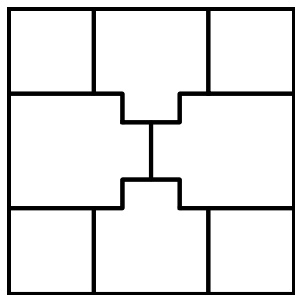

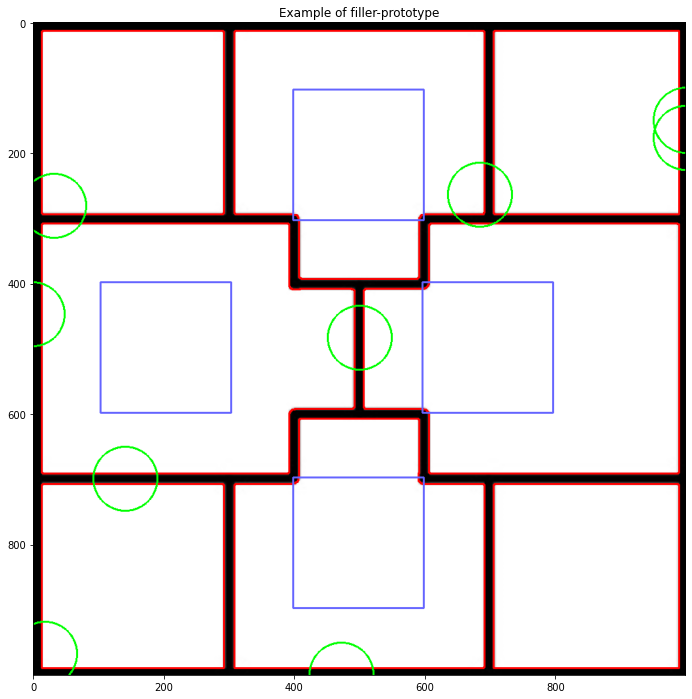

In [465]:
cnt = 8
pieces = [[
    Piece(color='gray', label='Rectangle', position=np.asarray([[0,0], [0,200], [100, 200], [100, 0]])),
    Piece(color='green', label='Square 1', position=np.asarray([[0,0], [0,100], [100, 100], [100, 0]]))
] for _ in range(cnt//2)] + [[
    Piece(color='blue', label='Rectangle', position=np.asarray([[0,0], [200,0], [200, 200], [0, 200]]))
] for _ in range(cnt//2)]

house = fill_up_the_house(generate_rooms(rooms_cnt=cnt), pieces, cnt)
plt.figure(figsize=(12,12))
plt.title("Example of filler-prototype")

plt.imshow(house)

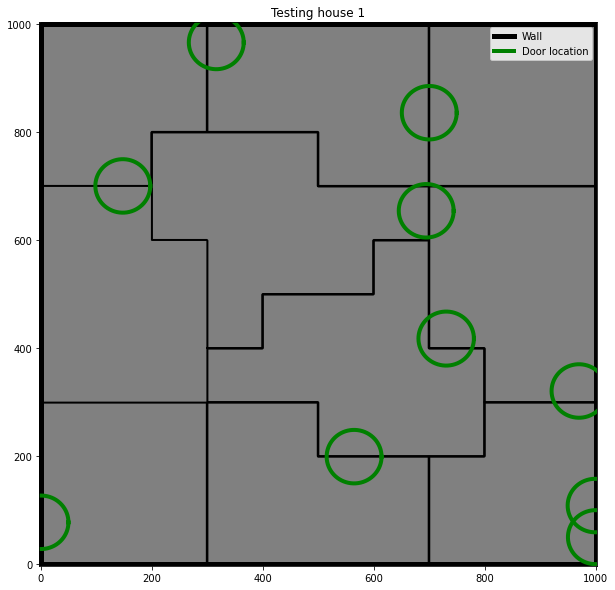

In [472]:
simple_house = generate_rooms(rooms_cnt=10)
simple_house.title = "Testing house 1"
simple_house.draw()

# To be done:
* Clear trash
* Optimization
* Windows [on walls]
* Z-axis
* Complex pieces volumes
* Count doors correctly
* Apply A* for pieces displacement